In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from detector import DetectorModule
import detector as de
from particle import Particle

In [2]:
# Detector Setting
detectors = []
detectors += de.Set_Detector_Module(25, 25, 0, 25)
detectors += de.Set_Detector_Module(50, 50, 25, 25)
detectors += de.Set_Detector_Module(100, 100, 75, 50)
detectors += de.Set_Detector_Module(100, 100, 100, 100)

In [ ]:
# Cost
de.Get_Price(detectors)

Total price is within budget: 2183


In [4]:
# Color Setting
def get_rainbow_colors(n):
    cmap = plt.cm.rainbow
    return [cmap(i / n) for i in range(n)]
colors = get_rainbow_colors(7)
#colors = sns.color_palette("husl", 7).as_hex()
z_to_color = {}

def get_color_by_z(z):
    if z not in z_to_color:
        z_to_color[z] = colors[len(z_to_color) % len(colors)]
    return z_to_color[z]

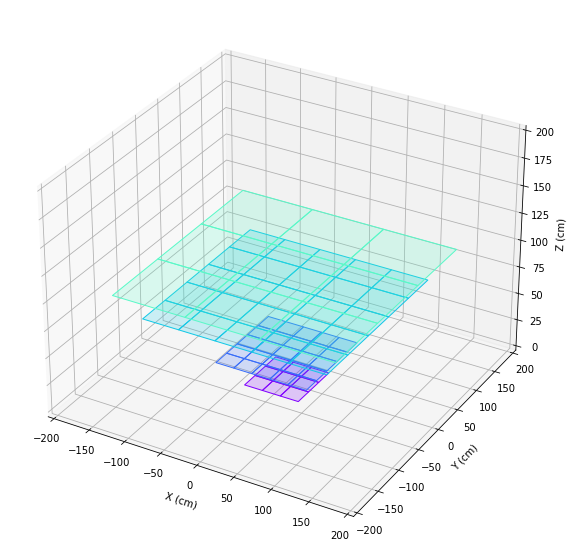

In [5]:
# Draw detectors
fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for d in detectors:
    z = d.position[2]
    color = get_color_by_z(z)
    d.plot(ax, color=color)

ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_zlim(0, 200)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')

plt.show()


In [6]:
# Particle Setting
P1 = Particle(direction=[1, 1, 1])

hit_detectors = [d for d in detectors if d.is_hit(P1)]

print(f"Particle go throuth {len(hit_detectors)} Detector")
for d in hit_detectors:
    print(f"Center of Detector: {d.position}, lenth: {d.size}")

Particle go throuth 4 Detector
Center of Detector: (0, 0, 0), lenth: 25
Center of Detector: (25, 25, 25), lenth: 25
Center of Detector: (100, 100, 75), lenth: 50
Center of Detector: (100, 100, 100), lenth: 100


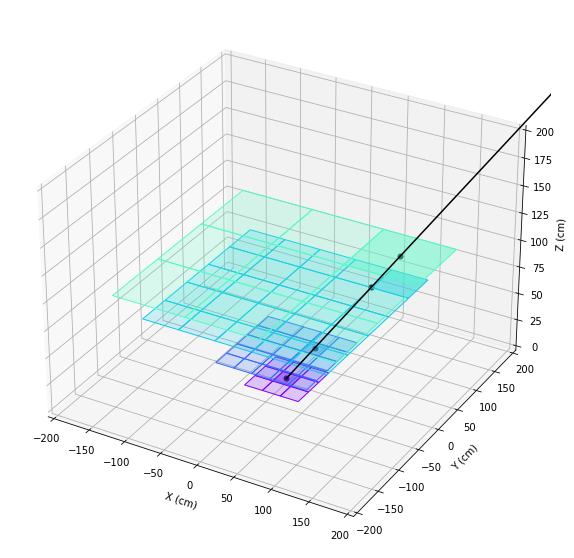

In [7]:
# Draw detectors and particle track
fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for d in detectors:
    z = d.position[2]
    color = get_color_by_z(z)
    if d in hit_detectors:
        pass
    else:
        d.plot(ax, color=color)

for d in hit_detectors:
    z = d.position[2]
    color = get_color_by_z(z)
    d.plot(ax, color=color)
    d.interaction_point(ax, P1)

ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_zlim(0, 200)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
# set high zorder value to make the track line drawn on top of all Detector Module
ax.plot([P1.position[0], P1.position_t(1000)[0]], [P1.position[1],P1.position_t(1000)[1]],[P1.position[2],P1.position_t(1000)[2]], color="black", zorder=100)
plt.show()

In [8]:
# Save hit Detector Module in CSV
def save_detector(detectors, particle, filename='detectors.csv'):
    with open(filename, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["x", "y", "z"])

        for det in detectors:
            if det.is_hit(particle):
                writer.writerow(det.position)

save_detector(detectors, P1)

In [9]:
# Save Truth Particle Track in CSV
def save_particle(particle, z_layers, filename='particle.csv'):
    with open(filename, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["x", "y", "z"])

        pos0 = particle.position
        dir = particle.direction

        for z in z_layers:
            t = (z - pos0[2]) / dir[2]
            point = pos0 + t * dir
            writer.writerow(point)

z_layers = sorted(set(d.position[2] for d in detectors))
# check
print(z_layers)

save_particle(P1, z_layers)

[0, 25, 75, 100]


-----

Detector 0 Center: (0, 0, 0) vs. Truth Particle (0.0, 0.0, 0.0)
Detector 1 Center: (25, 25, 25) vs. Truth Particle (25.0, 25.0, 25.0)
Detector 2 Center: (100, 100, 75) vs. Truth Particle (75.0, 75.0, 75.0)
Detector 3 Center: (100, 100, 100) vs. Truth Particle (100.0, 100.0, 100.0)


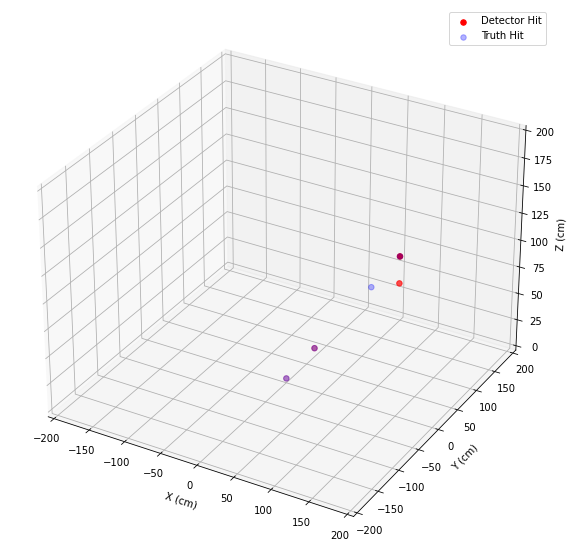

In [ ]:
# Read detector data and scatter
detector_data = pd.read_csv('detectors.csv')
truth_data = pd.read_csv('particle.csv')

points = detector_data[['x', 'y', 'z']].values
track = truth_data[['x', 'y', 'z']].values

x = points[:,0]
y = points[:,1]
z = points[:,2]

tx = track[:,0]
ty = track[:,1]
tz = track[:,2]

for i in range(len(x)):
    print(f"Detector {i} Center: ({x[i]}, {y[i]}, {z[i]}) vs. Truth Particle ({tx[i]}, {ty[i]}, {tz[i]})")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', s=30, label='Detector Hit', marker='o')
ax.scatter(tx, ty, tz, c='b', s=30, label='Truth Hit', marker='o', alpha=0.3)
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_zlim(0, 200)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')

plt.legend()
plt.show()

[[ 6.01231288e-01  6.01231288e-01  5.26347676e-01]
 [-3.72184011e-01 -3.72184011e-01  8.50269442e-01]
 [ 7.07106781e-01 -7.07106781e-01 -1.04671113e-16]]
[0.60123129 0.60123129 0.52634768]


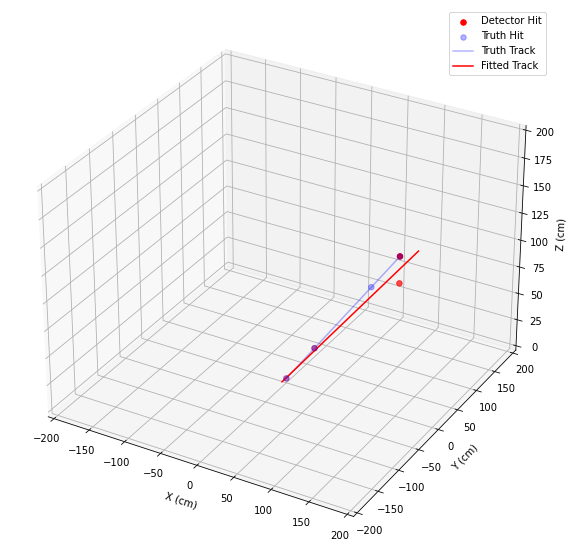

In [40]:
## Fitting
# Problem: fitting method

centroid = points.mean(axis=0)

centered = points - centroid

_, _, vh = np.linalg.svd(centered)
print(vh)
direction = vh[0]
print(direction)

t_vals = np.linspace(-100, 100, 100)
line_points = centroid + t_vals[:, np.newaxis] * direction


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', s=30, label='Detector Hit', marker='o')
ax.scatter(tx, ty, tz, c='b', s=30, label='Truth Hit', marker='o', alpha=0.3)
ax.plot(tx, ty, tz, c='b', label='Truth Track', alpha=0.3)
ax.plot(line_points[:, 0], line_points[:, 1], line_points[:, 2], c='r', label='Fitted Track')

ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_zlim(0, 200)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.legend()
plt.show()

In [39]:
t = np.arange(points.shape[0])

def linear_fit(t, y):
    A = np.vstack([t, np.ones(len(t))]).T  # 设计矩阵
    params, residuals, _, _ = np.linalg.lstsq(A, y, rcond=None)
    return params  # 返回 [a, b]

params_x = linear_fit(t, points[:, 0])
params_y = linear_fit(t, points[:, 1])
params_z = linear_fit(t, points[:, 2])

print("拟合结果：")
print(f"x(t) = {params_x[0]:.3f} * t + {params_x[1]:.3f}")
print(f"y(t) = {params_y[0]:.3f} * t + {params_y[1]:.3f}")
print(f"z(t) = {params_z[0]:.3f} * t + {params_z[1]:.3f}")

t_fit = np.linspace(t[0], t[-1], 100)
x_fit = params_x[0] * t_fit + params_x[1]
y_fit = params_y[0] * t_fit + params_y[1]
z_fit = params_z[0] * t_fit + params_z[1]

dir = np.array([params_x[0], params_y[0], params_z[0]])
dir /= np.linalg.norm(dir)
print(dir)

拟合结果：
x(t) = 37.500 * t + 0.000
y(t) = 37.500 * t + 0.000
z(t) = 35.000 * t + -2.500
[0.59016711 0.59016711 0.55082263]


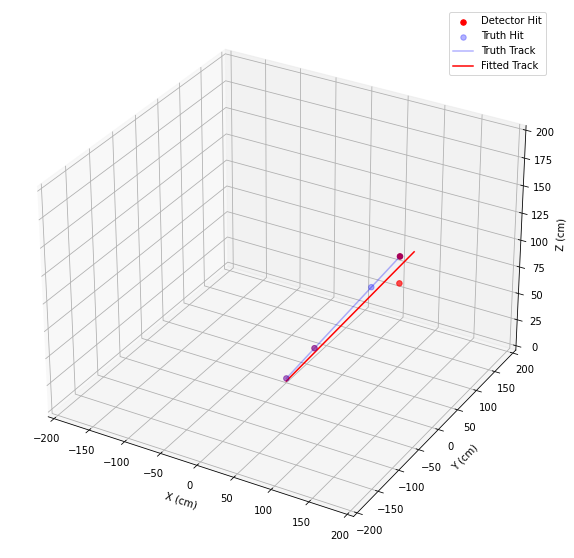

In [47]:
## Fitting
# Problem: fitting method

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', s=30, label='Detector Hit', marker='o')
ax.scatter(tx, ty, tz, c='b', s=30, label='Truth Hit', marker='o', alpha=0.3)
ax.plot(tx, ty, tz, c='b', label='Truth Track', alpha=0.3)
ax.plot(x_fit, y_fit, z_fit, c='r', label='Fitted Track')


ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_zlim(0, 200)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.legend()
plt.show()

-----

In [ ]:
# Angular Deviation
# smaller angle means better fit

def angular_deviation(vec1, vec2):
    v1 = vec1 / np.linalg.norm(vec1)
    v2 = vec2 / np.linalg.norm(vec2)
    cos_theta = np.clip(np.dot(v1, v2), -1.0, 1.0)
    return np.arccos(cos_theta)

v1 = P1.direction
v2 = direction

a = angular_deviation(v2, v1)
print(a)

0.06118037249467386


In [43]:
a = angular_deviation(dir, v1)
print(a)

0.03213015626957118


For calculating Residual, RMSE and R^2, following one using detector modules coordinates and truth track, maybe wrong. We should consider the fitting track, not the recorded points.

[ 0.          0.         35.35533906  0.        ]


Text(0, 0.5, 'Residual (cm)')

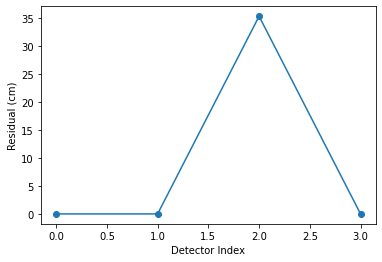

In [20]:
# Residual
# Residuals are the distances from the points to the fitted line

residuals = np.linalg.norm(points - track, axis=1)
print(residuals)

plt.plot(residuals, marker='o')
plt.xlabel('Detector Index')
plt.ylabel('Residual (cm)')

In [ ]:
# RMSE
rmse = np.sqrt(np.mean(np.linalg.norm(points - track, axis=1)**2))
print(f"RMSE: {rmse:.2f} cm")

RMSE: 17.68 cm


In [ ]:
# R^2

# 平均点
mean_point = np.mean(points, axis=0)
print(f"Mean Point: {mean_point}")

# 总平方和（SST）
sst = np.sum(np.linalg.norm(points - mean_point, axis=1) ** 2)
print( f"SST: {sst:.2f}")

# 残差平方和（SSR）
ssr = np.sum(np.linalg.norm(points - track, axis=1) ** 2)
print(f"SSR: {ssr:.2f}")

# R²
r_squared = 1 - ssr / sst

print(f"R²: {r_squared:.4f}")


Mean Point: [56.25 56.25 50.  ]
SST: 22187.50
SSR: 1250.00
R²: 0.9437
